In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.model_selection import train_test_split, RandomizedSearchCV, KFold
from sklearn.metrics import mean_squared_error, root_mean_squared_error

In [2]:
df = pd.read_csv("bismillah.csv")

## One-Hot Encoder

In [3]:
from sklearn.preprocessing import OneHotEncoder

df = pd.concat([df, pd.get_dummies(df['kota'], prefix='kota')], axis=1)
df = pd.concat([df, pd.get_dummies(df['kecamatan'], prefix='kecamatan')], axis=1)
df.drop(['kota', 'kecamatan'], axis=1, inplace=True)
df.head()

,kamar_tidur,kamar_mandi,luas,harga,kota_Banjar,kota_Banjarbaru,kota_Banjarmasin,kota_Barito,kota_Kalimantan,kecamatan_Alalak,...,kecamatan_Banjarmasin Tengah,kecamatan_Banjarmasin Timur,kecamatan_Banjarmasin Utara,kecamatan_Gambut,kecamatan_Kertak Hanyar,kecamatan_Landasan Ulin,kecamatan_Liang Anggang,kecamatan_Martapura Kota,kecamatan_Sei/Sungai Tabuk,kecamatan_Tatah Makmur
0,2,2,70,400000000,False,False,True,False,False,False,...,False,True,False,False,False,False,False,False,False,False
1,2,1,60,400000000,False,False,True,False,False,False,...,False,True,False,False,False,False,False,False,False,False
2,2,1,120,550000000,False,False,True,False,False,False,...,False,False,True,False,False,False,False,False,False,False
3,3,2,100,555000000,False,False,True,False,False,False,...,False,False,True,False,False,False,False,False,False,False
4,2,1,45,400000000,False,False,True,False,False,False,...,False,True,False,False,False,False,False,False,False,False


## Split Train Test

In [4]:
X = df.drop(columns=['harga'])
y = df['harga']

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size = 0.2, 
                                                    random_state = 137)

## Standard Scaler

In [6]:
from sklearn.preprocessing import StandardScaler

numerical_features = ['kamar_mandi', 'kamar_tidur', 'luas']
scaler = StandardScaler()
scaler.fit(X_train[numerical_features])
X_train[numerical_features] = scaler.transform(X_train.loc[:, numerical_features])

In [7]:
target_scaler = StandardScaler()
y_train_scaled = target_scaler.fit_transform(y_train.values.reshape(-1, 1)).flatten()

## RandomizedSearchCV

In [8]:
svr = svm.SVR()

param_grid = {'C': np.linspace(0.001, 100),
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['linear', 'poly', 'rbf', 'sigmoid']}

In [14]:
random_search = RandomizedSearchCV(
    estimator=svr,
    param_distributions=param_grid,
    n_iter=50,
    scoring='neg_mean_squared_error',
    cv=5,
    random_state=42,
    verbose=10
)

random_search.fit(X_train, y_train_scaled)

print(f"Best parameters: {random_search.best_params_}")
print(f"Best cross-validation score: {random_search.best_score_}")

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV 1/5; 1/50] START C=53.061693877551015, gamma=1, kernel=poly.................
[CV 1/5; 1/50] END C=53.061693877551015, gamma=1, kernel=poly;, score=-4.717 total time=  10.9s
[CV 2/5; 1/50] START C=53.061693877551015, gamma=1, kernel=poly.................
[CV 2/5; 1/50] END C=53.061693877551015, gamma=1, kernel=poly;, score=-14.295 total time=  48.3s
[CV 3/5; 1/50] START C=53.061693877551015, gamma=1, kernel=poly.................
[CV 3/5; 1/50] END C=53.061693877551015, gamma=1, kernel=poly;, score=-5.520 total time=   9.7s
[CV 4/5; 1/50] START C=53.061693877551015, gamma=1, kernel=poly.................
[CV 4/5; 1/50] END C=53.061693877551015, gamma=1, kernel=poly;, score=-9.400 total time=  23.1s
[CV 5/5; 1/50] START C=53.061693877551015, gamma=1, kernel=poly.................
[CV 5/5; 1/50] END C=53.061693877551015, gamma=1, kernel=poly;, score=-73.507 total time=  10.0s
[CV 1/5; 2/50] START C=73.46965306122449, gamma=0.0

In [16]:
print(random_search.best_params_)
print(random_search.best_estimator_.get_params())

{'kernel': 'rbf', 'gamma': 0.001, 'C': 97.95920408163265}
{'C': 97.95920408163265, 'cache_size': 200, 'coef0': 0.0, 'degree': 3, 'epsilon': 0.1, 'gamma': 0.001, 'kernel': 'rbf', 'max_iter': -1, 'shrinking': True, 'tol': 0.001, 'verbose': False}


## Model Development

In [17]:
svr_new = svm.SVR(C= 97.95920408163265, 
                  gamma= 0.001, 
                  kernel= 'rbf')

svr_new.fit(X_train, y_train_scaled)

y_pred = svr_new.predict(X_test)

## Model Evaluation

In [18]:
rmse = root_mean_squared_error(y_test, y_pred)
mse = mean_squared_error(y_pred, y_test)
print(f"RMSE:{rmse} and MSE:{mse}")

RMSE:636362070.1018481 and MSE:4.049566842643095e+17


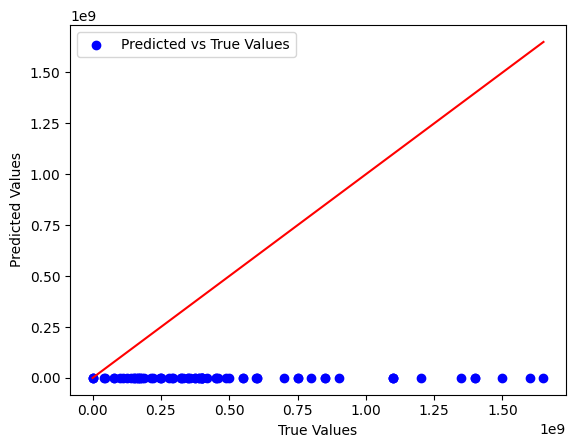

In [19]:
plt.scatter(y_test, y_pred, color='blue', label='Predicted vs True Values')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.legend()
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red')  # Diagonal line for reference
plt.show()